## Import Data

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '../scripts'))
if project_root not in sys.path:
    sys.path.append(project_root)

from data_preprocessing import load_and_preprocess_data
from ofi_calculation import compute_ofi_for_btc, integrate_multi_level_ofi
from cross_impact_analysis import (
    compute_short_term_returns,
    run_regression_ofi_vs_returns,
    visualize_ofi_vs_returns
)

# Set some display options
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

# Load the BTC data
csv_path = os.path.join('..', 'data', 'BTC_1min.csv')
df_btc = load_and_preprocess_data(csv_path)
df_btc.head()


,Unnamed: 0,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,bids_distance_5,bids_distance_6,bids_distance_7,bids_distance_8,bids_distance_9,bids_distance_10,bids_distance_11,bids_distance_12,bids_distance_13,bids_distance_14,bids_notional_0,bids_notional_1,bids_notional_2,bids_notional_3,...,asks_limit_notional_5,asks_limit_notional_6,asks_limit_notional_7,asks_limit_notional_8,asks_limit_notional_9,asks_limit_notional_10,asks_limit_notional_11,asks_limit_notional_12,asks_limit_notional_13,asks_limit_notional_14,asks_market_notional_0,asks_market_notional_1,asks_market_notional_2,asks_market_notional_3,asks_market_notional_4,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,0,2021-04-07 11:33:41.122161+00:00,55896.285,0.01,4.448599e+06,3.899402e+06,-8.945138e-08,-0.000065,-0.000073,-0.000154,-0.000162,-0.000162,-0.000242,-0.000271,-0.000291,-0.000329,-0.000418,-0.000481,-0.000490,-0.000522,-0.000567,714.909973,107.680000,8942.750000,819.309998,...,559.010010,916.799988,916.809998,1.118130e+03,19568.910156,64.019997,66986.742188,87239.789062,87239.796875,1424.520020,411.549988,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1176.72998,0.0
1,1,2021-04-07 11:34:41.122161+00:00,55948.685,1.43,1.243244e+06,3.606502e+06,-1.277957e-05,-0.000013,-0.000242,-0.000242,-0.000259,-0.000259,-0.000264,-0.000436,-0.000458,-0.000458,-0.000513,-0.000524,-0.000609,-0.000711,-0.000711,2797.399902,5702.669922,5168.939941,1120.310059,...,108.000000,16467.460938,34287.031250,4.754058e+06,11.190000,279780.000000,108.019997,2238.370117,0.000000,67034.460938,1410.209961,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,2,2021-04-07 11:35:41.122161+00:00,56013.785,0.01,3.069094e+06,1.575759e+06,-8.926374e-08,-0.000009,-0.000070,-0.000088,-0.000173,-0.000177,-0.000244,-0.000273,-0.000383,-0.000383,-0.000405,-0.000472,-0.000473,-0.000487,-0.000502,95037.171875,5276.810059,2998.340088,2800.439941,...,2251.949951,2802.580078,20003.830078,8.744089e+04,2802.629883,26736.289062,87449.203125,2214.610107,19620.660156,61.669998,2476.370117,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,3,2021-04-07 11:36:41.122161+00:00,55903.575,7.17,1.220819e+06,1.321487e+06,-6.412827e-05,-0.000182,-0.000188,-0.000225,-0.000310,-0.000314,-0.000317,-0.000381,-0.000431,-0.000471,-0.000560,-0.000561,-0.000600,-0.000601,-0.000649,722.719971,714.880005,8383.959961,22.360001,...,82198.773438,3511.439941,279625.000000,2.241000e+03,19991.910156,64.040001,107.980003,2796.689941,2796.699951,67003.328125,146.210007,47.779999,0.0,0.0,0.0,0.0,312.040009,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,4,2021-04-07 11:37:41.122161+00:00,55899.995,0.01,2.011287e+06,3.083005e+06,-8.944544e-08,-0.000129,-0.000130,-0.000143,-0.000201,-0.000201,-0.000240,-0.000271,-0.000387,-0.000399,-0.000424,-0.000588,-0.000588,-0.000629,-0.000727,18997.929688,746.049988,1117.859985,2794.600098,...,0.000000,2164.229980,19576.220703,6.700102e+04,52967.460938,105933.867188,53012.140625,64.040001,26541.439453,777499.625000,1986.449951,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


## Investigate Data

In [9]:
print("Data shape:", df_btc.shape)
print(df_btc.info())

# Check basic stats
df_btc.describe()

Data shape: (17113, 156)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17113 entries, 0 to 17112
Columns: 156 entries, Unnamed: 0 to asks_market_notional_14
dtypes: datetime64[ns, UTC](1), float64(154), int64(1)
memory usage: 20.4 MB
None


,Unnamed: 0,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,bids_distance_5,bids_distance_6,bids_distance_7,bids_distance_8,bids_distance_9,bids_distance_10,bids_distance_11,bids_distance_12,bids_distance_13,bids_distance_14,bids_notional_0,bids_notional_1,bids_notional_2,bids_notional_3,bids_notional_4,...,asks_limit_notional_5,asks_limit_notional_6,asks_limit_notional_7,asks_limit_notional_8,asks_limit_notional_9,asks_limit_notional_10,asks_limit_notional_11,asks_limit_notional_12,asks_limit_notional_13,asks_limit_notional_14,asks_market_notional_0,asks_market_notional_1,asks_market_notional_2,asks_market_notional_3,asks_market_notional_4,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
count,17113.000000,17113.000000,17113.000000,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,17113.000000,17113.000000,17113.000000,17113.000000,17113.000000,17113.000000,17113.000000,17113.000000,17113.000000,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,...,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,1.711300e+04,17113.000000,1.711300e+04,1.711300e+04,17113.000000,17113.000000,17113.000000,1.711300e+04,1.711300e+04,1.711300e+04,17113.000000,1.711300e+04,17113.000000,17113.000000
mean,8556.000000,59974.016782,1.293919,3.378894e+05,2.940671e+05,-1.094052e-05,-4.746012e-05,-7.788031e-05,-1.043243e-04,-1.282323e-04,-1.511178e-04,-0.000172,-0.000193,-0.000212,-0.000232,-0.000250,-0.000270,-0.000289,-0.000309,-0.000328,7.515561e+04,1.825590e+04,2.229840e+04,2.235824e+04,2.119845e+04,...,4.951030e+04,5.044117e+04,4.543203e+04,5.198889e+04,4.799715e+04,4.874492e+04,1.455869e+05,4.955489e+04,4.352933e+04,4.566306e+04,1.105265e+04,1.111543e+03,766.778637,8.788113e+02,1.079583e+03,532.433194,450.022713,445.134314,5.226304e+02,6.050031e+02,6.705292e+02,540.288290,4.210821e+02,324.351408,325.901278
std,4940.241914,2489.942801,4.001627,5.256141e+05,6.268850e+05,3.500733e-05,6.266660e-05,7.563535e-05,8.722111e-05,9.686198e-05,1.063818e-04,0.000114,0.000121,0.000127,0.000134,0.000142,0.000148,0.000155,0.000164,0.000169,1.517693e+05,4.619829e+04,7.403015e+04,5.872263e+04,5.091369e+04,...,2.101829e+05,2.489846e+05,2.016677e+05,3.659578e+05,3.368646e+05,2.791158e+05,1.280591e+07,4.200831e+05,3.234200e+05,4.735453e+05,8.439619e+04,2.162137e+04,8120.678002,1.750680e+04,5.194688e+04,7666.994870,5235.755748,7299.243458,1.031326e+04,1.692391e+04,3.199046e+04,10772.403045,9.221210e+03,4433.084651,4459.675017
min,0.000000,52430.650000,0.010000,1.542180e+03,1.304606e+02,-1.472060e-03,-1.482892e-03,-1.596353e-03,-1.596537e-03,-1.624811e-03,-2.438486e-03,-0.002439,-0.002439,-0.002504,-0.002727,-0.002777,-0.003003,-0.003488,-0.004399,-0.004399,0.000000e+00,1.200000e-01,1.200000e-01,0.000000e+00,1.080000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,4278.000000,58000.005000,0.010000,8.817576e+04,5.621674e+04,-8.883438e-08,-6.961533e-05,-1.065353e-04,-1.408942e-04,-1.700931e-04,-1.978485e-04,-0.000222,-0.000246,-0.000266,-0.000286,-0.000307,-0.000328,-0.000347,-0.000368,-0.000389,1.588180e+03,8.568500e+02,9.211900e+02,9.205400e+02,9.204400e+02,...,1.088360e+03,1.129870e+03,1.162990e+03,1.264930e+03,1.274780e+03,1.531300e+03,1.700480e+03,1.701430e+03,1.743320e+03,1.635120e+03,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0

## OFI calculation

In [10]:
df_btc = compute_ofi_for_btc(df_btc, max_levels=5)

# Take a look at the newly created columns
ofi_cols = [col for col in df_btc.columns if col.startswith('OFI_level_')]
df_btc[ofi_cols].head(10)

,OFI_level_0,OFI_level_1,OFI_level_2,OFI_level_3,OFI_level_4
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,-1.111756e+05,-3.918718e+05,8.039508e+04,-3.145992e+04,-2.519970e+06
2,2.957146e+06,-2.944250e+05,-3.281883e+06,4.197076e+04,-2.510629e+05
3,7.904494e+07,-1.543817e+05,2.065246e+07,4.746238e+06,1.375244e+06
4,4.670443e+06,2.921182e+03,4.832257e+05,1.511271e+05,1.026043e+04
5,-1.074018e+08,1.272775e+05,-1.540208e+06,7.166947e+05,1.096409e+06
6,3.052124e+05,2.278342e+03,3.148026e+04,-3.243653e+04,6.571129e+02
7,-2.549295e+06,-1.018391e+06,-1.182347e+05,1.843440e+04,1.188404e+04
8,-8.088923e+05,-9.090207e+06,-1.107687e+05,-4.488644e+06,-2.953899e+06
9,5.670969e+05,4.065084e+06,7.510776e+05,5.136007e+06,6.320355e+06


## Future income calculation

In [11]:
# Integrate multi-level OFI
df_btc = integrate_multi_level_ofi(df_btc, max_levels=5, method='sum')

# Compute future returns (1-step for demonstration)
df_btc = compute_short_term_returns(df_btc, horizon=1)

df_btc[['system_time', 'OFI_aggregated', 'future_ret_1']].head(10)

,system_time,OFI_aggregated,future_ret_1
0,2021-04-07 11:33:41.122161+00:00,0.000000e+00,0.000937
1,2021-04-07 11:34:41.122161+00:00,-2.974082e+06,0.001164
2,2021-04-07 11:35:41.122161+00:00,-8.282536e+05,-0.001968
3,2021-04-07 11:36:41.122161+00:00,1.056645e+08,-0.000064
4,2021-04-07 11:37:41.122161+00:00,5.317977e+06,0.003581
5,2021-04-07 11:38:41.122161+00:00,-1.070016e+08,-0.000035
6,2021-04-07 11:39:41.122161+00:00,3.071916e+05,0.000271
7,2021-04-07 11:40:41.122161+00:00,-3.655601e+06,0.001389
8,2021-04-07 11:41:41.122161+00:00,-1.745241e+07,-0.001418
9,2021-04-07 11:42:41.122161+00:00,1.683962e+07,0.000638


## Regression Analysis

In [13]:
results = run_regression_ofi_vs_returns(df_btc, horizon=1)
print("Linear regression of future_ret_1 ~ OFI_aggregated:")
print(f"  Coefficient: {results['Coefficient']:.6f}")
print(f"  Intercept:  {results['Intercept']:.6f}")
print(f"  R^2:        {results['R^2']:.6f}")

Linear regression of future_ret_1 ~ OFI_aggregated:
  Coefficient: -0.000000
  Intercept:  0.000003
  R^2:        0.000741


## Visualization

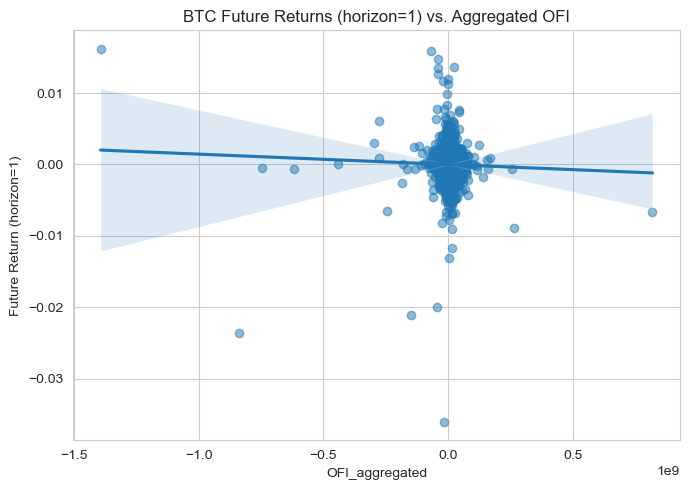

In [14]:
visualize_ofi_vs_returns(df_btc, horizon=1)

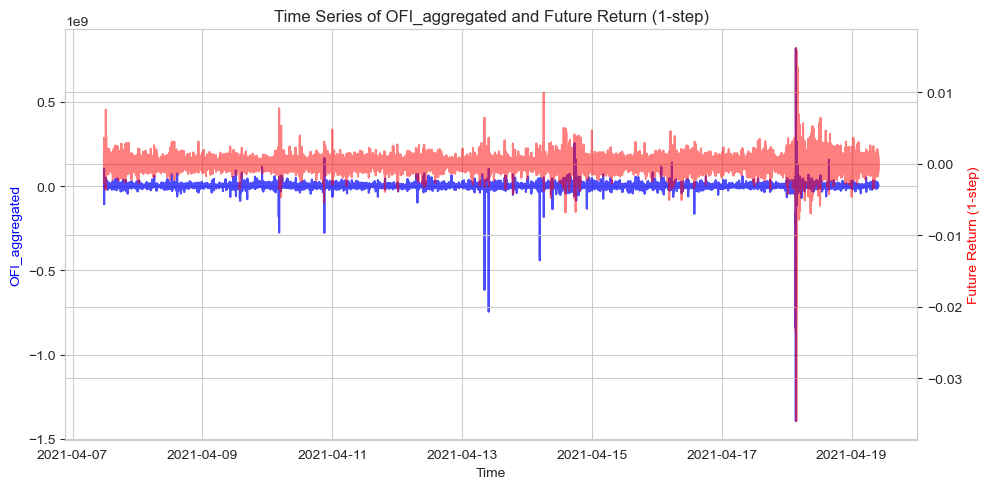

In [15]:
# Plot the time series of OFI_aggregated and future_ret_1
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(df_btc['system_time'], df_btc['OFI_aggregated'], color='blue', alpha=0.7, label='OFI_aggregated')
ax1.set_ylabel('OFI_aggregated', color='blue')
ax1.set_xlabel('Time')

ax2 = ax1.twinx()
ax2.plot(df_btc['system_time'], df_btc['future_ret_1'], color='red', alpha=0.5, label='future_ret_1')
ax2.set_ylabel('Future Return (1-step)', color='red')

plt.title("Time Series of OFI_aggregated and Future Return (1-step)")
fig.tight_layout()
plt.show()
